In [7]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd

import warnings

warnings.filterwarnings("ignore")


class AntColonyOptimizer:
    def __init__(self, ants, evaporation_rate, intensification, alpha=1.0, beta=0.0,\
        beta_evaporation_rate=0,choose_best=.1):
        """
        Ant colony optimizer.  Traverses a graph and finds either the max or min distance between nodes.
        :param ants: number of ants to traverse the graph
        :param evaporation_rate: rate at which pheromone evaporates
        :param intensification: constant added to the best path
        :param alpha: weighting of pheromone
        :param beta: weighting of heuristic (1/distance)
        :param beta_evaporation_rate: rate at which beta decays (optional)
        :param choose_best: probability to choose the best route
        """
        # Parameters
        self.ants = ants
        self.evaporation_rate = evaporation_rate
        self.pheromone_intensification = intensification
        self.heuristic_alpha = alpha
        self.heuristic_beta = beta
        self.beta_evaporation_rate = beta_evaporation_rate
        self.choose_best = choose_best

        # Internal representations
        self.pheromone_matrix = None
        self.heuristic_matrix = None
        self.probability_matrix = None

        self.map = None
        self.set_of_available_nodes = None

        # Internal stats
        self.best_series = []
        self.best = None
        self.fitted = False
        self.best_path = None
        self.fit_time = None

        # Plotting values
        self.stopped_early = False

    def __str__(self):
        string = "Ant Colony Optimizer"
        string += "\n--------------------"
        string += "\nDesigned to optimize either the minimum or maximum distance between nodes in a square matrix that behaves like a distance matrix."
        string += "\n--------------------"
        string += "\nNumber of ants:\t\t\t\t{}".format(self.ants)
        string += "\nEvaporation rate:\t\t\t{}".format(self.evaporation_rate)
        string += "\nIntensification factor:\t\t{}".format(self.pheromone_intensification)
        string += "\nAlpha Heuristic:\t\t\t{}".format(self.heuristic_alpha)
        string += "\nBeta Heuristic:\t\t\t\t{}".format(self.heuristic_beta)
        string += "\nBeta Evaporation Rate:\t\t{}".format(self.beta_evaporation_rate)
        string += "\nChoose Best Percentage:\t\t{}".format(self.choose_best)
        string += "\n--------------------"
        string += "\nUSAGE:"
        string += "\nNumber of ants influences how many paths are explored each iteration."
        string += "\nThe alpha and beta heuristics affect how much influence the pheromones or the distance heuristic weigh an ants' decisions."
        string += "\nBeta evaporation reduces the influence of the heuristic over time."
        string += "\nChoose best is a percentage of how often an ant will choose the best route over probabilistically choosing a route based on pheromones."
        string += "\n--------------------"
        if self.fitted:
            string += "\n\nThis optimizer has been fitted."
        else:
            string += "\n\nThis optimizer has NOT been fitted."
        return string

    def _initialize(self):
        """
        Initializes the model by creating the various matrices and generating the list of available nodes
        """
        assert self.map.shape[0] == self.map.shape[1], "Map is not a distance matrix!"
        num_nodes = self.map.shape[0]
        self.pheromone_matrix = np.ones((num_nodes, num_nodes))
        # Remove the diagonal since there is no pheromone from node i to itself
        self.pheromone_matrix[np.eye(num_nodes) == 1] = 0
        self.heuristic_matrix = 1 / self.map
        self.probability_matrix = (self.pheromone_matrix ** self.heuristic_alpha) * (
                self.heuristic_matrix ** self.heuristic_beta)  # element by element multiplcation
        self.set_of_available_nodes = list(range(num_nodes))

    def _reinstate_nodes(self):
        """
        Resets available nodes to all nodes for the next iteration
        """
        self.set_of_available_nodes = list(range(self.map.shape[0]))

    def _update_probabilities(self):
        """
        After evaporation and intensification, the probability matrix needs to be updated.  This function
        does that.
        """
        self.probability_matrix = (self.pheromone_matrix ** self.heuristic_alpha) * (
                self.heuristic_matrix ** self.heuristic_beta)

    def _choose_next_node(self, from_node):
        """
        Chooses the next node based on probabilities.  If p < p_choose_best, then the best path is chosen, otherwise
        it is selected from a probability distribution weighted by the pheromone.
        :param from_node: the node the ant is coming from
        :return: index of the node the ant is going to
        """
        numerator = self.probability_matrix[from_node, self.set_of_available_nodes]
        if np.random.random() < self.choose_best:
            next_node = np.argmax(numerator)
        else:
            denominator = np.sum(numerator)
            probabilities = numerator / denominator
            next_node = np.random.choice(range(len(probabilities)), p=probabilities)
        return next_node

    def _remove_node(self, node):
        self.set_of_available_nodes.remove(node)

    def _evaluate(self, paths, mode):
        """
        Evaluates the solutions of the ants by adding up the distances between nodes.
        :param paths: solutions from the ants
        :param mode: max or min
        :return: x and y coordinates of the best path as a tuple, the best path, and the best score
        """
        scores = np.zeros(len(paths))
        coordinates_i = []
        coordinates_j = []
        for index, path in enumerate(paths):
            score = 0
            coords_i = []
            coords_j = []
            for i in range(len(path) - 1):
                coords_i.append(path[i])
                coords_j.append(path[i + 1])
                score += self.map[path[i], path[i + 1]]
            scores[index] = score
            coordinates_i.append(coords_i)
            coordinates_j.append(coords_j)
        if mode == 'min':
            best = np.argmin(scores)
        elif mode == 'max':
            best = np.argmax(scores)
        return (coordinates_i[best], coordinates_j[best]), paths[best], scores[best]

    def _evaporation(self):
        """
        Evaporate some pheromone as the inverse of the evaporation rate.  Also evaporates beta if desired.
        """
        self.pheromone_matrix *= (1 - self.evaporation_rate)
        self.heuristic_beta *= (1 - self.beta_evaporation_rate)

    def _intensify(self, best_coords):
        """
        Increases the pheromone by some scalar for the best route.
        :param best_coords: x and y (i and j) coordinates of the best route
        """
        i = best_coords[0]
        j = best_coords[1]
        self.pheromone_matrix[i, j] += self.pheromone_intensification

    def fit(self, map_matrix, iterations=100, mode='min', early_stopping_count=20, verbose=True):
        """
        Fits the ACO to a specific map.  This was designed with the Traveling Salesman problem in mind.
        :param map_matrix: Distance matrix or some other matrix with similar properties
        :param iterations: number of iterations
        :param mode: whether to get the minimum path or maximum path
        :param early_stopping_count: how many iterations of the same score to make the algorithm stop early
        :return: the best score
        """
        if verbose: print("Beginning ACO Optimization with {} iterations...".format(iterations))
        self.map = map_matrix
        start = time.time()
        self._initialize()
        num_equal = 0

        for i in range(iterations):
            start_iter = time.time()
            paths = []
            path = []

            for ant in range(self.ants):
                current_node = self.set_of_available_nodes[np.random.randint(0, len(self.set_of_available_nodes))]
                start_node = current_node
                while True:
                    path.append(current_node)
                    self._remove_node(current_node)
                    if len(self.set_of_available_nodes) != 0:
                        current_node_index = self._choose_next_node(current_node)
                        current_node = self.set_of_available_nodes[current_node_index]
                    else:
                        break

                path.append(start_node)  # go back to start
                self._reinstate_nodes()
                paths.append(path)
                path = []

            best_path_coords, best_path, best_score = self._evaluate(paths, mode)

            if i == 0:
                best_score_so_far = best_score
            else:
                if mode == 'min':
                    if best_score < best_score_so_far:
                        best_score_so_far = best_score
                        self.best_path = best_path
                elif mode == 'max':
                    if best_score > best_score_so_far:
                        best_score_so_far = best_score
                        self.best_path = best_path

            if best_score == best_score_so_far:
                num_equal += 1
            else:
                num_equal = 0

            self.best_series.append(best_score)
            self._evaporation()
            self._intensify(best_path_coords)
            self._update_probabilities()

            if verbose: print("Best score at iteration {}: {}; overall: {} ({}s)"
                            "".format(i, round(best_score, 2), round(best_score_so_far, 2),
                                        round(time.time() - start_iter))); print(best_path)

            if best_score == best_score_so_far and num_equal == early_stopping_count:
                self.stopped_early = True
                print("Stopping early due to {} iterations of the same score.".format(early_stopping_count))
                print(best_path)
                break

        self.fit_time = round(time.time() - start)
        self.fitted = True

        if mode == 'min':
            self.best = self.best_series[np.argmin(self.best_series)]
            if verbose: print(
                "ACO fitted.  Runtime: {} minutes.  Best score: {}".format(self.fit_time // 60, self.best))
                
            return self.best
        elif mode == 'max':
            self.best = self.best_series[np.argmax(self.best_series)]
            if verbose: print(
                "ACO fitted.  Runtime: {} minutes.  Best score: {}".format(self.fit_time // 60, self.best))
            return self.best
        else:
            raise ValueError("Invalid mode!  Choose 'min' or 'max'.")
    
    def plot(self):
        """
        Plots the score over time after the model has been fitted.
        :return: None if the model isn't fitted yet
        """
        if not self.fitted:
            print("Ant Colony Optimizer not fitted!  There exists nothing to plot.")
            return None
        else:
            fig, ax = plt.subplots(figsize=(20, 15))
            ax.plot(self.best_series, label="Best Run")
            ax.set_xlabel("Iteration")
            ax.set_ylabel("Performance")
            ax.text(.8, .6,
                    'Ants: {}\nEvap Rate: {}\nIntensify: {}\nAlpha: {}\nBeta: {}\nBeta Evap: {}\nChoose Best: {}\n\nFit Time: {}m{}'.format(
                        self.ants, self.evaporation_rate, self.pheromone_intensification, self.heuristic_alpha,
                        self.heuristic_beta, self.beta_evaporation_rate, self.choose_best, self.fit_time // 60,
                        ["\nStopped Early!" if self.stopped_early else ""][0]),
                    bbox={'facecolor': 'gray', 'alpha': 0.8, 'pad': 10}, transform=ax.transAxes)
            ax.legend()
            plt.title("Ant Colony Optimization Results (best: {})".format(np.round(self.best, 2)))
            plt.show()





In [8]:
import pandas as pd
import numpy as np
from scipy.spatial import distance

def maker(df):
    X = df.iloc[:,[2]].values
    Y = df.iloc[:,[1]].values
    # Z = np.hstack([X,Y])
    
    arr = np.zeros((50,50))
    df_1 = pd.DataFrame(arr)

    for i in range(len(X)):
        for j in range(len(X)):
            df_1.iloc[i,j] = ((X[i] - X[j]) ** 2 +  (Y[i] - Y[j]) ** 2) ** 1/2
    print(df_1)

    # X_cdist_cityblock = distance.cdist(Z, Z, metric='cityblock')

    return df_1


In [9]:
# import pandas as pd
# df = pd.read_csv("DBSCAN_주기사.csv")
# df = df.drop(columns = ['Unnamed: 0'])

# df

In [10]:
# import pandas as pd
# df = pd.read_excel("../1.데이터/20230323_clustering.xlsx")
# df = pd.DataFrame(maker(df))


# d = len(df)
# df

In [47]:
import numpy as np
from numpy import inf


#given values for the problems

import pandas as pd
df = pd.read_excel("../1.데이터/20230323_clustering.xlsx")
df = pd.DataFrame(maker(df[:]))

dis = len(df)

# for i in range(dis):
#     for j in range(dis):
#         df.iloc[i,j] = int(df.iloc[i,j])
# print(df)

df = df.to_numpy()



d = df
iteration = 100
n_ants = dis*3
n_citys = dis

# intialization part

m = n_ants
n = n_citys
e = .5         #evaporation rate
alpha = 1     #pheromone factor
beta = 2       #visibility factor

#calculating the visibility of the next city visibility(i,j)=1/d(i,j)

visibility = 1/d
visibility[visibility == inf ] = 0

#intializing pheromne present at the paths to the cities

pheromne = .1*np.ones((m,n))

#intializing the rute of the ants with size rute(n_ants,n_citys+1) 
#note adding 1 because we want to come back to the source city

rute = np.ones((m,n+1))

for ite in range(iteration):
    
    rute[:,0] = 1          #initial starting and ending positon of every ants '1' i.e city '1'
    
    for i in range(m):
        
        temp_visibility = np.array(visibility)         #creating a copy of visibility
        
        for j in range(n-1):
            #print(rute)
            
            combine_feature = np.zeros(5)     #intializing combine_feature array to zero
            cum_prob = np.zeros(5)            #intializing cummulative probability array to zeros
            
            cur_loc = int(rute[i,j]-1)        #current city of the ant
            
            temp_visibility[:,cur_loc] = 0     #making visibility of the current city as zero
            
            p_feature = np.power(pheromne[cur_loc,:],beta)         #calculating pheromne feature 
            v_feature = np.power(temp_visibility[cur_loc,:],alpha)  #calculating visibility feature
            
            p_feature = p_feature[:,np.newaxis]                     #adding axis to make a size[5,1]
            v_feature = v_feature[:,np.newaxis]                     #adding axis to make a size[5,1]
            
            combine_feature = np.multiply(p_feature,v_feature)     #calculating the combine feature
                        
            total = np.sum(combine_feature)                        #sum of all the feature
            
            probs = combine_feature/total   #finding probability of element probs(i) = comine_feature(i)/total
            
            cum_prob = np.cumsum(probs)     #calculating cummulative sum
            #print(cum_prob)
            r = np.random.random_sample()   #randon no in [0,1)
            #print(r)
            city = np.nonzero(cum_prob>r)[0][0]+1       #finding the next city having probability higher then random(r) 
            #print(city)
            
            rute[i,j+1] = city              #adding city to route 
           
        left = list(set([i for i in range(1,n+1)])-set(rute[i,:-2]))[0]     #finding the last untraversed city to route
        
        rute[i,-2] = left                   #adding untraversed city to route
       
    rute_opt = np.array(rute)               #intializing optimal route
    
    dist_cost = np.zeros((m,1))             #intializing total_distance_of_tour with zero 
    
    for i in range(m):
        
        s = 0
        for j in range(n-1):
            
            s = s + d[int(rute_opt[i,j])-1,int(rute_opt[i,j+1])-1]   #calcualting total tour distance
        
        dist_cost[i]=s                      #storing distance of tour for 'i'th ant at location 'i' 
       
    dist_min_loc = np.argmin(dist_cost)             #finding location of minimum of dist_cost
    dist_min_cost = dist_cost[dist_min_loc]         #finging min of dist_cost
    
    best_route = rute[dist_min_loc,:]               #intializing current traversed as best route
    pheromne = (1-e)*pheromne                       #evaporation of pheromne with (1-e)
    
    for i in range(m):
        for j in range(n-1):
            dt = 1/dist_cost[i]
            pheromne[int(rute_opt[i,j])-1,int(rute_opt[i,j+1])-1] = pheromne[int(rute_opt[i,j])-1,int(rute_opt[i,j+1])-1] + dt   
            #updating the pheromne with delta_distance
            #delta_distance will be more with min_dist i.e adding more weight to that route  peromne

print('route of all the ants at the end :')
print(rute_opt)
print()
print('best path :',best_route)
print('cost of the best path',int(dist_min_cost[0]) + d[int(best_route[-2])-1,0])

              0             1             2         3             4    
0   0.000000e+00  9.317903e-06  9.164547e-06  0.000040  5.510857e-06  \
1   9.317903e-06  0.000000e+00  1.316743e-05  0.000026  3.090733e-06   
2   9.164547e-06  1.316743e-05  0.000000e+00  0.000013  3.517141e-06   
3   3.952052e-05  2.557069e-05  1.305771e-05  0.000000  1.690806e-05   
4   5.510857e-06  3.090733e-06  3.517141e-06  0.000017  0.000000e+00   
5   5.616201e-06  2.168291e-05  2.886123e-05  0.000075  2.102478e-05   
6   1.256181e-06  5.901154e-06  1.383564e-05  0.000043  6.029234e-06   
7   2.605360e-06  1.079304e-05  2.149361e-06  0.000025  3.084882e-06   
8   2.433087e-06  1.555762e-05  2.097443e-05  0.000061  1.419322e-05   
9   9.912907e-06  1.401253e-06  7.170895e-06  0.000015  1.024666e-06   
10  2.507412e-05  2.293301e-05  4.050498e-06  0.000004  1.086176e-05   
11  8.805630e-07  4.716304e-06  6.901890e-06  0.000031  2.204566e-06   
12  5.670211e-06  9.209474e-06  5.161384e-07  0.000016  1.655263

In [48]:
best_route_new = best_route[:-1]
print(len(best_route_new))
route = []
for i in range(len(best_route_new)):
    for j, k in enumerate(best_route_new):
        if int(i+1) == int(k):
            route.append(j)
len(route)


50


50

In [49]:
df = pd.read_excel("../1.데이터/20230323_clustering.xlsx")
X = []
Y = []
for i in df.iloc[:,2]:
    X.append(i)
for i in df.iloc[:,1]:
    Y.append(i)
asdf = pd.DataFrame(zip(X, Y, route))
asdf

,0,1,2
0,127.041776,37.734124,0
1,127.043610,37.738031,30
2,127.046011,37.733496,44
3,127.050467,37.735998,48
4,127.044656,37.735775,22
5,127.038428,37.733968,12
6,127.041188,37.735595,39
7,127.043940,37.733397,17
8,127.039571,37.734185,9
9,127.045037,37.737155,25


In [50]:
path_indices = best_route[:-1]-1
print(path_indices)
path_indices = path_indices.astype(np.int32)
path_indices

[ 0. 33. 27. 34. 45. 13. 41. 24. 48.  8. 30. 31.  5. 47. 25. 22. 43.  7.
 26. 18. 28. 40.  4. 39. 14.  9. 23. 36. 32. 37.  1. 42. 16. 20. 49. 19.
 11. 44. 35.  6. 38. 12. 29. 46.  2. 17. 10. 21.  3. 15.]


array([ 0, 33, 27, 34, 45, 13, 41, 24, 48,  8, 30, 31,  5, 47, 25, 22, 43,
        7, 26, 18, 28, 40,  4, 39, 14,  9, 23, 36, 32, 37,  1, 42, 16, 20,
       49, 19, 11, 44, 35,  6, 38, 12, 29, 46,  2, 17, 10, 21,  3, 15])

In [51]:
FullPoints = []
for i in range(len(X)):
    FullPoints.append([X[i], Y[i]])
FullPoints = np.array(FullPoints)
FullPoints

array([[127.04177597,  37.73412353],
       [127.0436104 ,  37.7380313 ],
       [127.04601093,  37.73349563],
       [127.0504666 ,  37.7359981 ],
       [127.0446557 ,  37.73577546],
       [127.0384281 ,  37.7339681 ],
       [127.04118784,  37.73559542],
       [127.04393994,  37.73339692],
       [127.03957087,  37.73418455],
       [127.04503698,  37.7371553 ],
       [127.04884693,  37.73373657],
       [127.04266435,  37.73510938],
       [127.045142  ,  37.73402217],
       [127.03951976,  37.7352816 ],
       [127.04518707,  37.73632763],
       [127.0475838 ,  37.7392456 ],
       [127.04410226,  37.73692827],
       [127.0457732 ,  37.73436915],
       [127.04471707,  37.73457212],
       [127.0431843 ,  37.7343685 ],
       [127.04368066,  37.73574896],
       [127.047849  ,  37.7357597 ],
       [127.04235828,  37.73383888],
       [127.04514418,  37.73748528],
       [127.03865142,  37.73452072],
       [127.04175927,  37.73356817],
       [127.04430738,  37.73394584],
 

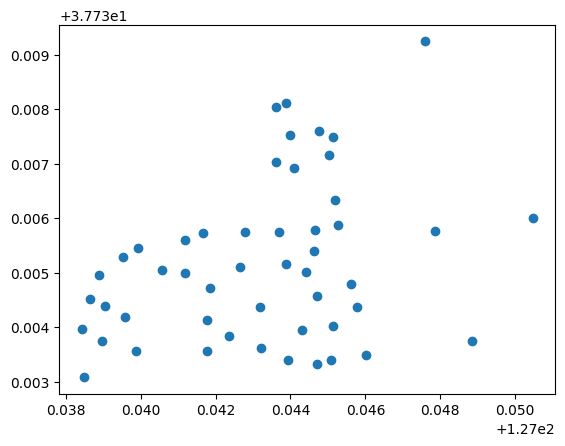

In [52]:
plt.figure()
plt.scatter(FullPoints[path_indices,0], FullPoints[path_indices,1])

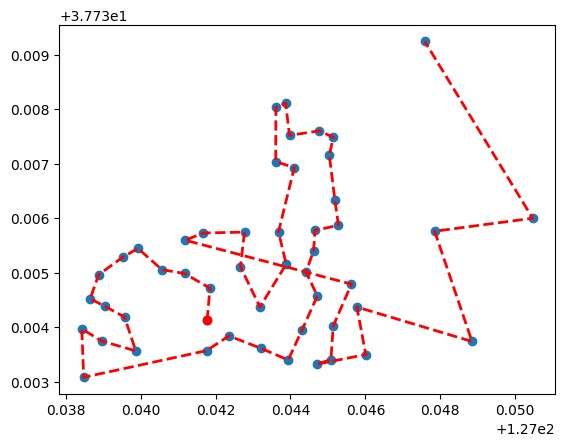

In [53]:
plt.figure()
plt.scatter(FullPoints[path_indices,0], FullPoints[path_indices,1])
plt.plot(FullPoints[path_indices,0], FullPoints[path_indices,1], 'r--', lw=2)
plt.plot(FullPoints[path_indices[0],0], FullPoints[path_indices[0],1], 'ro')


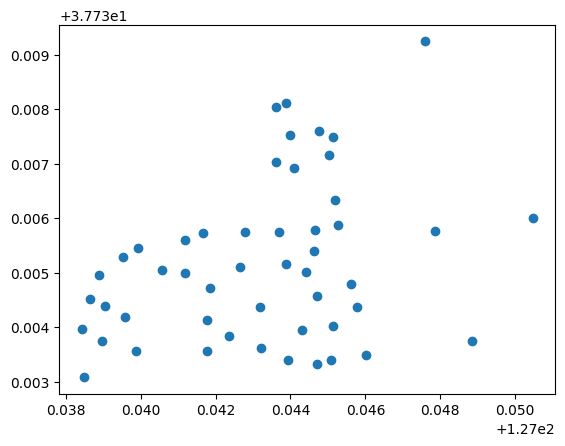

In [39]:
plt.figure()
plt.scatter(FullPoints[path_indices,0], FullPoints[path_indices,1])